In [36]:
#!apt update && apt install -y python3-opencv

In [38]:
import cv2
import imageio
import numpy as np
import matplotlib.pyplot as plt

(1381, 1500, 3)


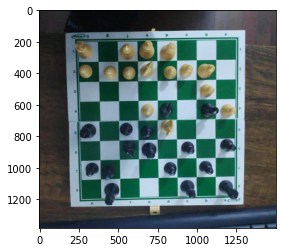

In [45]:
img = imageio.imread('my-data/image-20210616-223155.png')
w, h = img.shape[0], img.shape[1]
w, h = 1500, int(1500 * w / h)
img = cv2.resize(img, (w, h), interpolation = cv2.INTER_AREA)
print(img.shape)
plt.imshow(img)

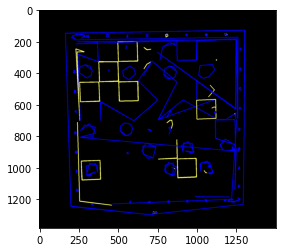

In [46]:
edge_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
edge_img = cv2.GaussianBlur(edge_img, (5, 5), 1)
edge_img = cv2.Canny(edge_img, 20, 200)

contours, hierarchy = cv2.findContours(edge_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
for i in range(len(contours)):
    contours[i] = cv2.approxPolyDP(contours[i], 0.04*cv2.arcLength(contours[i], True), True)
    pass
image = np.zeros_like(img)
for i, c in enumerate(contours):
    if c.shape[0] <= 1:
        continue
    #image[np.squeeze(c)[:, 1], np.squeeze(c)[:, 0]] = [255, 100, 100]
    if len(c) == 4:
        cv2.drawContours(image, contours, i, (255, 255, 100), 3)
    else:
        cv2.drawContours(image, contours, i, (0, 0, 255), 3)
#cv2.drawContours(image, contours, -1, (255, 255, 100), 3)
plt.imshow(image)

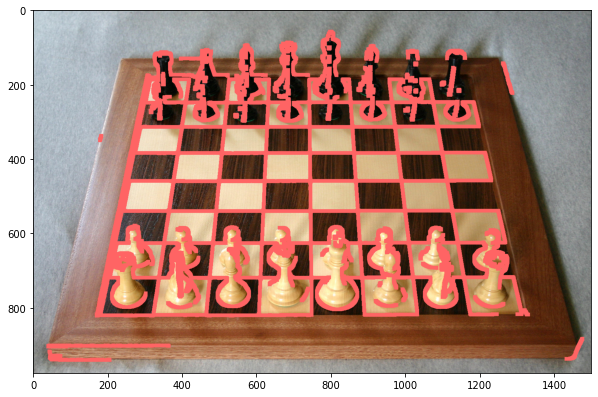

In [39]:
edge_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
edge_img = cv2.GaussianBlur(edge_img, (9, 9), 1)
edge_img = cv2.Canny(edge_img, 100, 200)
edge_img = cv2.dilate(
        edge_img,
        cv2.getStructuringElement(cv2.MORPH_RECT, (10, 10)),
        iterations=1
    )
image = np.copy(img)
image[edge_img == 255] = [255, 100, 100]
plt.figure(figsize=(10, 10))
plt.imshow(image)

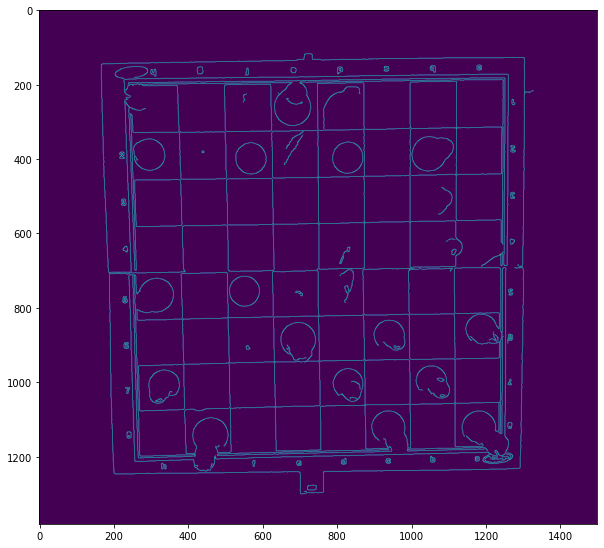

In [47]:
plt.figure(figsize=(10, 10))
plt.imshow(edge_img) 

63.25 137


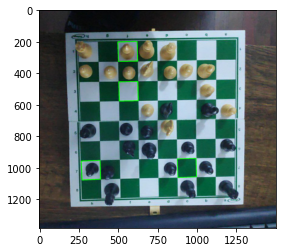

In [48]:
def get_angle(ab, ac):
    x = np.clip((ab @ ac) / np.linalg.norm(ab) / np.linalg.norm(ac), -1, 1)
    return np.degrees(np.arccos(x)) if not np.isnan(x) else 0

def check_square(points):
    a, b, c, d = np.squeeze(points)
    bcd = get_angle(b - c, d - c)
    cda = get_angle(c - d, a - d)
    dab = get_angle(d - a, b - a)
    abc = get_angle(a - b, c - b)

    return np.sum((np.array([bcd, cda, dab, abc]) - 90) ** 2), np.mean(np.abs([a - b, b - c, c - d, d - a]))

maxi, idx = 0, -1
squares = []
for i in range(len(contours)):
    if len(contours[i]) == 4:
        error, side = check_square(contours[i])
        if side < 8:
            continue
        if error < 5:
            squares.append(contours[i])
        if error < 3 and side > maxi:
            maxi, idx = side, i
print(maxi, idx)
image = np.copy(img)
cv2.drawContours(image, squares, -1, (0, 255, 0), 3)
plt.imshow(image)


329.25 35


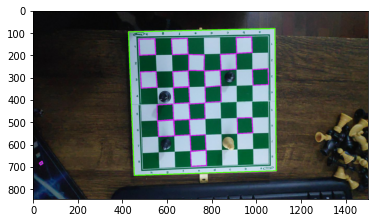

In [60]:
def go(img_name):
    img = imageio.imread(img_name)
    w, h = img.shape[0], img.shape[1]
    w, h = 1500, int(1500 * w / h)
    img = cv2.resize(img, (w, h), interpolation = cv2.INTER_AREA)

    edge_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edge_img = cv2.GaussianBlur(edge_img, (5, 5), 1)
    edge_img = cv2.Canny(edge_img, 20, 200)

    contours, hierarchy = cv2.findContours(edge_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    for i in range(len(contours)):
        contours[i] = cv2.approxPolyDP(contours[i], 0.04*cv2.arcLength(contours[i], True), True)
        pass
    image = np.zeros_like(img)
    for i, c in enumerate(contours):
        if c.shape[0] <= 1:
            continue
        #image[np.squeeze(c)[:, 1], np.squeeze(c)[:, 0]] = [255, 100, 100]
        if len(c) == 4:
            cv2.drawContours(image, contours, i, (255, 255, 100), 3)
        else:
            cv2.drawContours(image, contours, i, (0, 0, 255), 3)

    edge_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    edge_img = cv2.GaussianBlur(edge_img, (9, 9), 1)
    edge_img = cv2.Canny(edge_img, 100, 200)
    edge_img = cv2.dilate(
            edge_img,
            cv2.getStructuringElement(cv2.MORPH_RECT, (10, 10)),
            iterations=1
        )
    image = np.copy(img)
    image[edge_img == 255] = [255, 100, 100]

    maxi, idx = 0, -1
    squares = []
    for i in range(len(contours)):
        if len(contours[i]) == 4:
            error, side = check_square(contours[i])
            if side < 8:
                continue
            if error < 4 * 10 ** 2:
                squares.append(contours[i])
                if side > maxi:
                    maxi, idx = side, i
    print(maxi, idx)
    image = np.copy(img)
    cv2.drawContours(image, squares, -1, (207, 35, 229), 3)
    cv2.drawContours(image, contours, idx, (70, 255, 0), 3)
    plt.imshow(image)

go('my-data/image-20210616-221929.png')


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=a990a5a8-7c3e-4bd5-890f-4e9b644eb2a9' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>